<a href="https://colab.research.google.com/github/cocobryan91/tff_flnet/blob/main/Federated_Learning_Sim_TFF_FLNET2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tensorflow Federated: https://www.tensorflow.org/federated

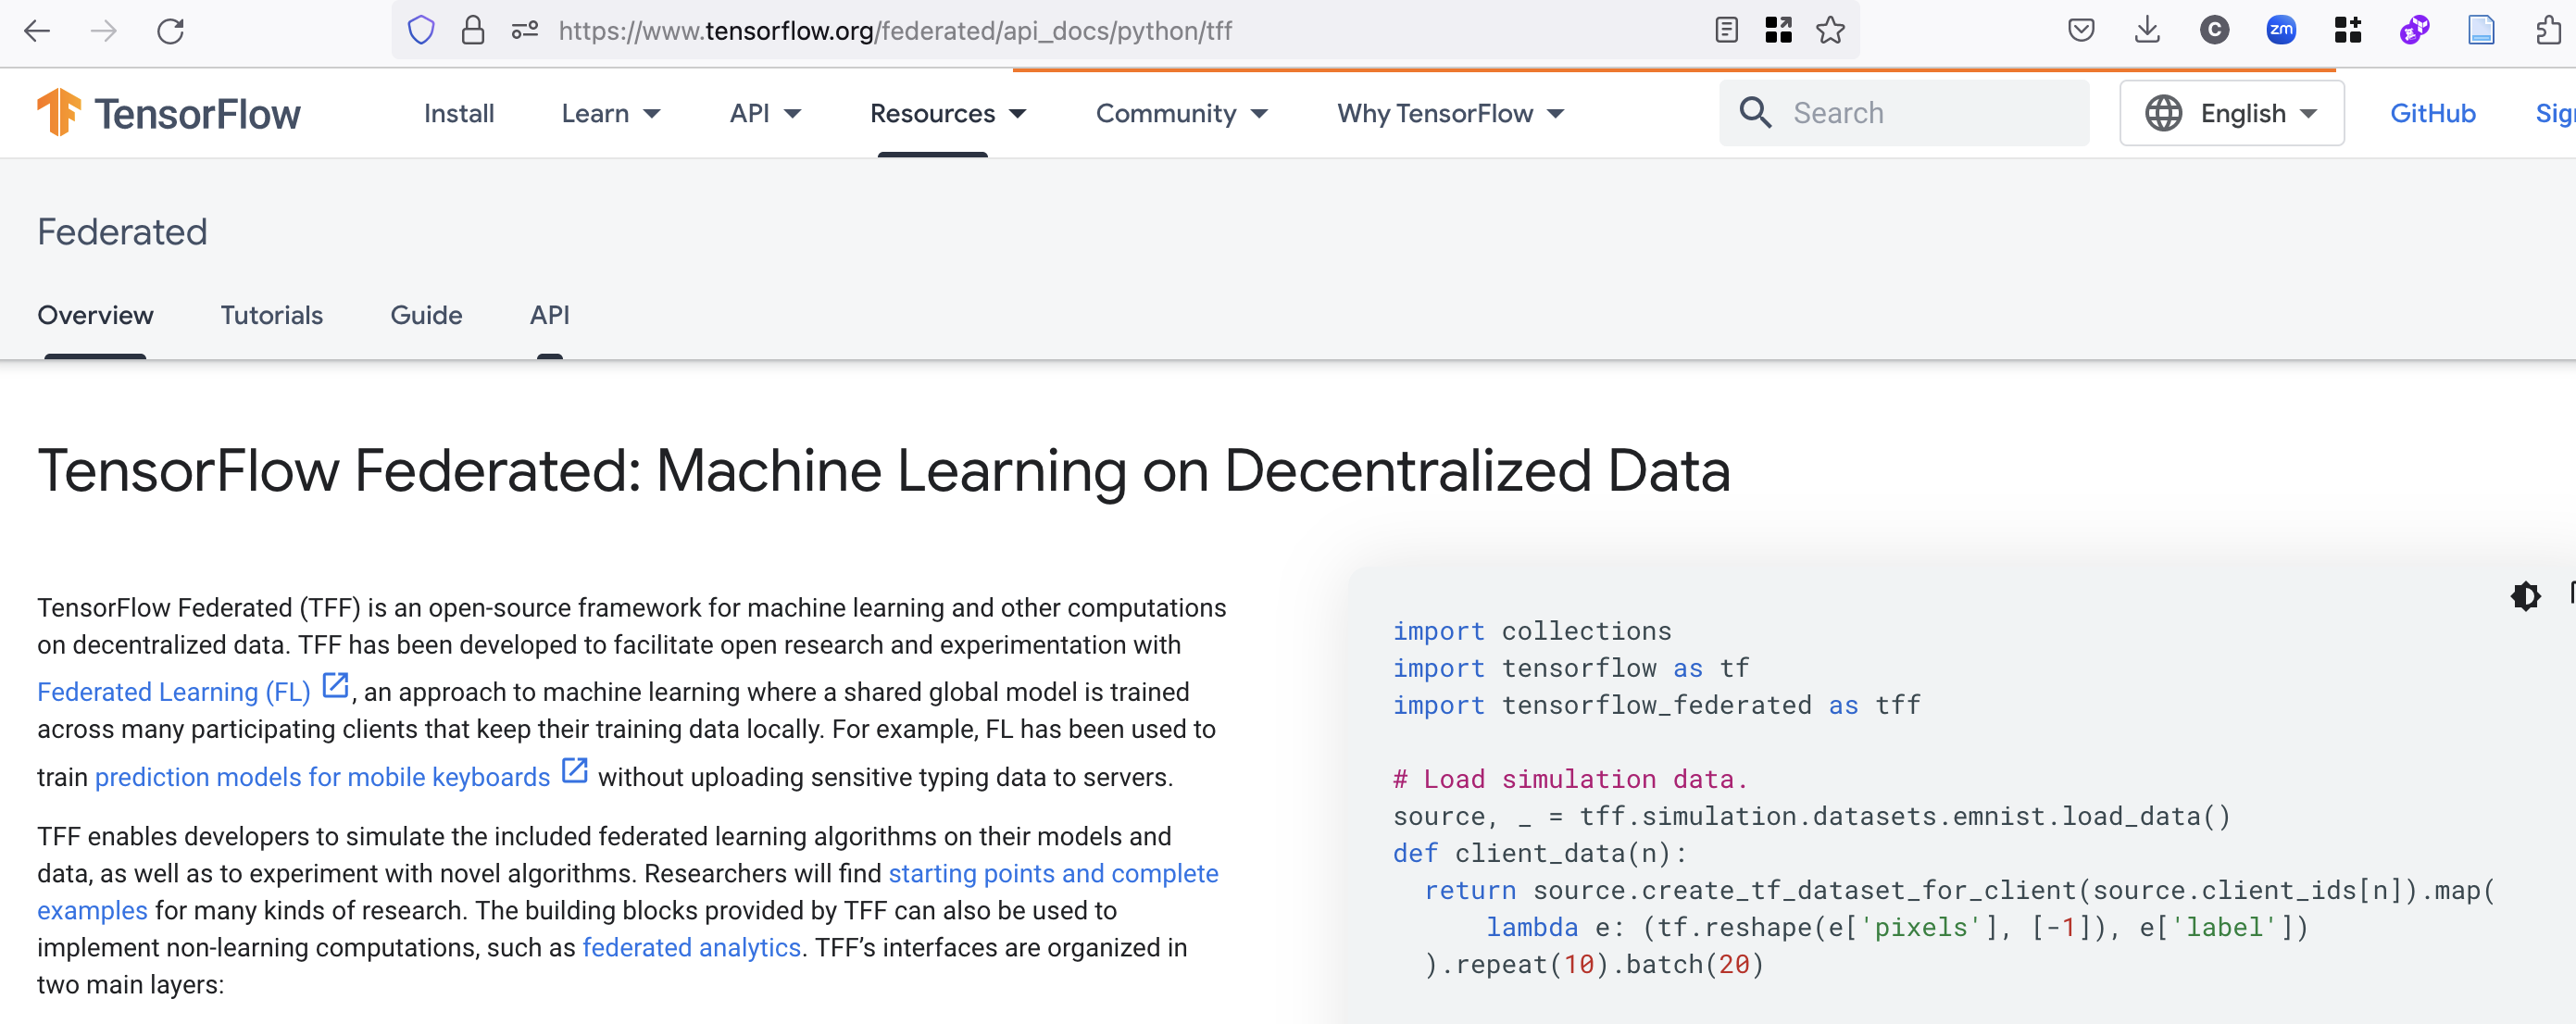

# Setup

In [ ]:
!pip install tensorflow-federated==0.71  # Tensorflow Python Modules
!pip install nest_asyncio

In [ ]:
!pip freeze  # Python Modules installed

absl-py==1.4.0
aiohttp==3.9.3
aiosignal==1.3.1
alabaster==0.7.16
albumentations==1.3.1
altair==4.2.2
annotated-types==0.6.0
anyio==3.7.1
appdirs==1.4.4
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array-record==0.5.0
arviz==0.15.1
astropy==5.3.4
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.0
attrs==23.1.0
audioread==3.0.1
autograd==1.6.2
Babel==2.14.0
backcall==0.2.0
beautifulsoup4==4.12.3
bidict==0.23.1
bigframes==1.0.0
bleach==6.1.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.3.4
bqplot==0.12.43
branca==0.7.1
build==1.1.1
CacheControl==0.14.0
cached-property==1.5.2
cachetools==5.3.3
catalogue==2.0.10
certifi==2024.2.2
cffi==1.16.0
chardet==5.2.0
charset-normalizer==3.3.2
chex==0.1.6
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloudpathlib==0.16.0
cloudpickle==2.2.1
cmake==3.27.9
cmdstanpy==1.2.1
colorama==0.4.6
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.4
cons==0.4.6
contextlib2==21.6.0
contourpy==1.2.0
cryptography==42.0.5
cu

Dataset: https://github.com/nsol-nmsu/FML-Network
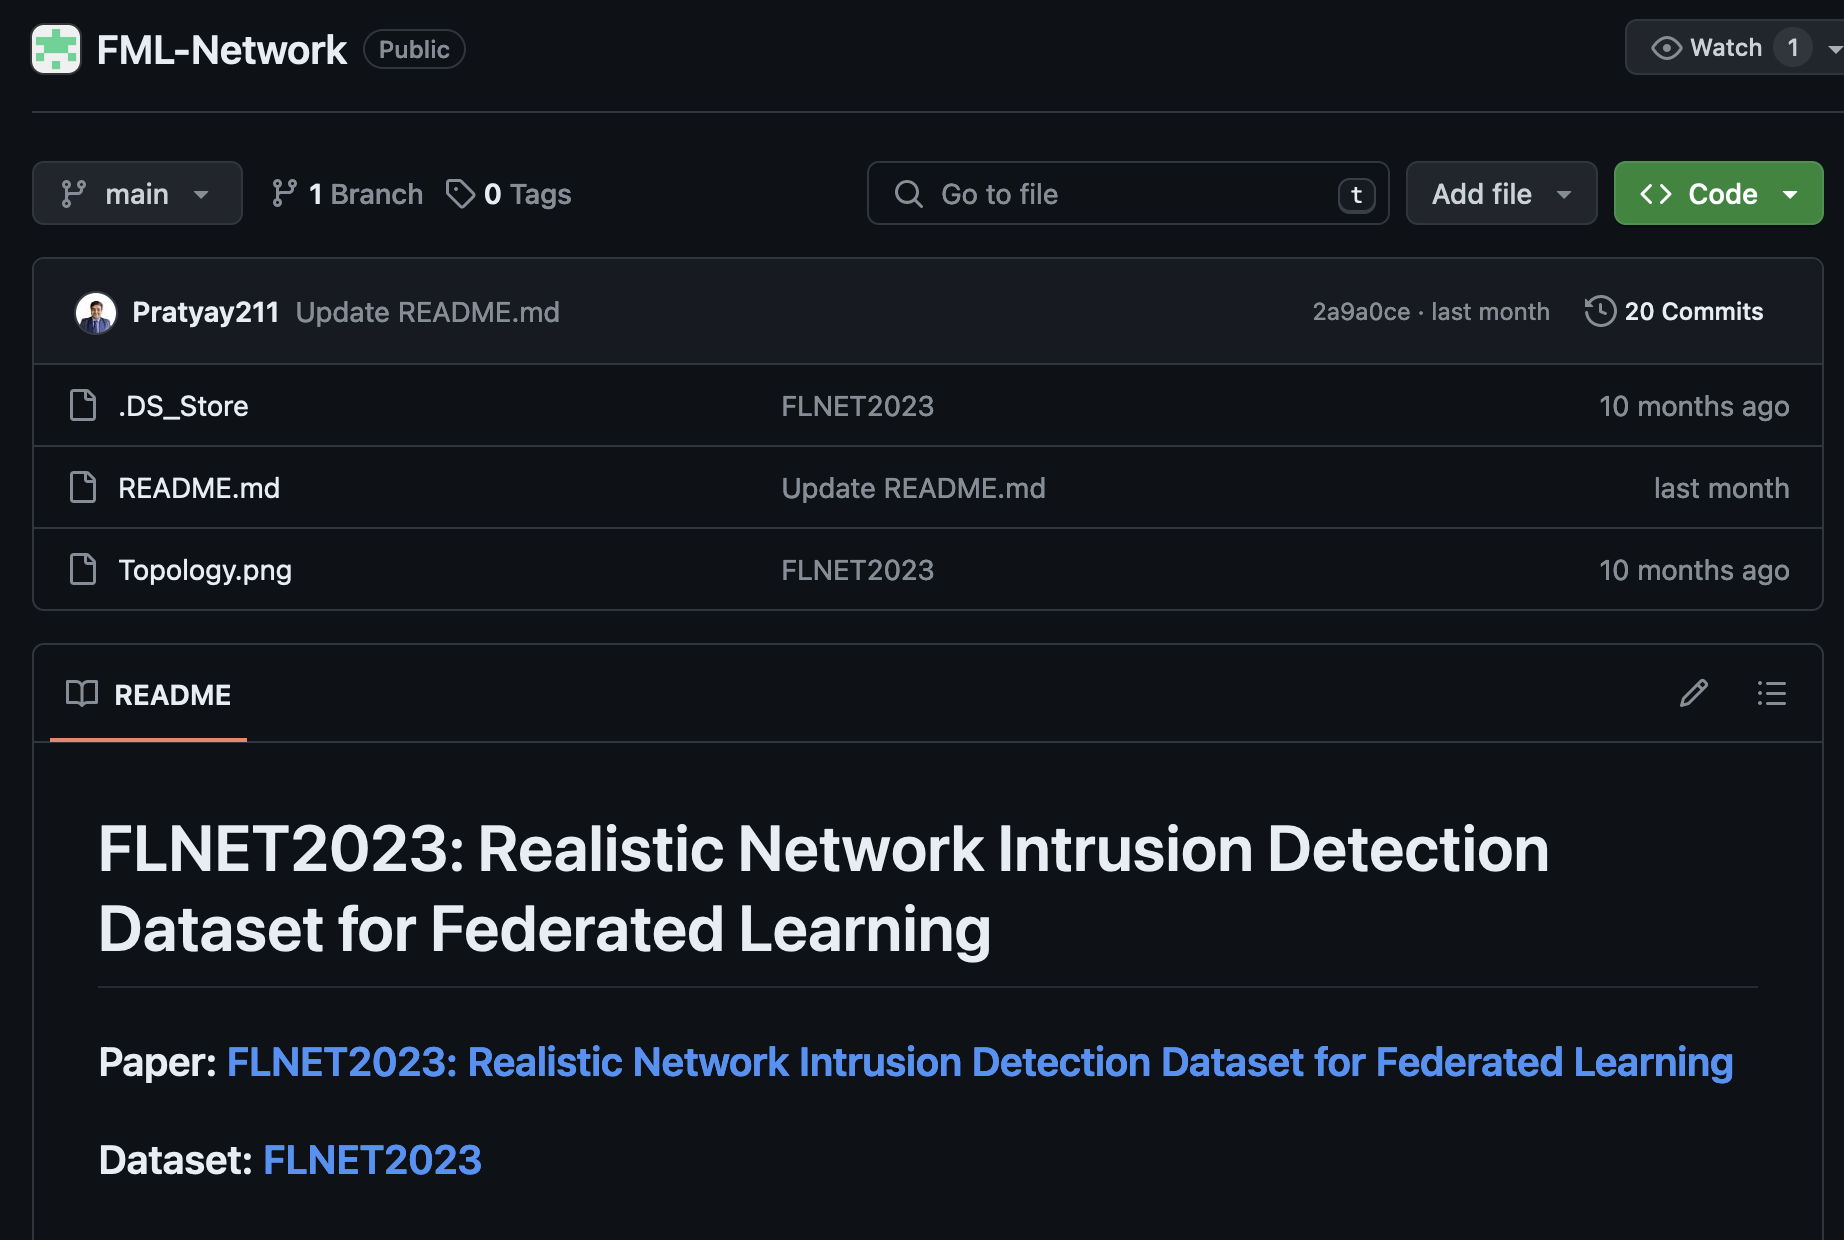


# Load Dataset Parameters

In [ ]:
fraction = 0.2  # get a sample records

SEED=1000
# np.random.seed(SEED)

# Load Dataset

In [ ]:
from google.colab import drive  # uploaded dataset to Google Drive
drive.mount('/content/drive')  # mount the Google Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Python Modules

In [ ]:
%load_ext tensorboard

In [ ]:
import nest_asyncio
import time

import collections

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_federated as tff

import gc

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

nest_asyncio.apply()
np.random.seed(SEED)

In [ ]:
# tff.federated_computation(lambda: 'Hello, World!')() # check if TFF is properly installed

In [ ]:
pd.set_option('display.max_columns', 120)  # see all columnns

# Preprocessing Parameters

In [ ]:
NUM_CLIENTS = 10  # number of devices training
NUM_EPOCHES = 1  # number of one full cycle of training
NUM_ROUND = 20  # number of rounds of training
BATCH_SIZE = 32  # number of samples per round
LEARNING_RATE = 0.001  # step size at each round moving towards the loss function

# Preprocessing

## Generate pandas.DataFrame file for training
Generate train data: normal + attacks
Get only a fraction or sample


In [ ]:
column_names_orig = ['src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol', 'timestamp',
       'flow_duration', 'flow_byts_s', 'flow_pkts_s', 'fwd_pkts_s',
       'bwd_pkts_s', 'tot_fwd_pkts', 'tot_bwd_pkts', 'totlen_fwd_pkts',
       'totlen_bwd_pkts', 'fwd_pkt_len_max', 'fwd_pkt_len_min',
       'fwd_pkt_len_mean', 'fwd_pkt_len_std', 'bwd_pkt_len_max',
       'bwd_pkt_len_min', 'bwd_pkt_len_mean', 'bwd_pkt_len_std', 'pkt_len_max',
       'pkt_len_min', 'pkt_len_mean', 'pkt_len_std', 'pkt_len_var',
       'fwd_header_len', 'bwd_header_len', 'fwd_seg_size_min',
       'fwd_act_data_pkts', 'flow_iat_mean', 'flow_iat_max', 'flow_iat_min',
       'flow_iat_std', 'fwd_iat_tot', 'fwd_iat_max', 'fwd_iat_min',
       'fwd_iat_mean', 'fwd_iat_std', 'bwd_iat_tot', 'bwd_iat_max',
       'bwd_iat_min', 'bwd_iat_mean', 'bwd_iat_std', 'fwd_psh_flags',
       'bwd_psh_flags', 'fwd_urg_flags', 'bwd_urg_flags', 'fin_flag_cnt',
       'syn_flag_cnt', 'rst_flag_cnt', 'psh_flag_cnt', 'ack_flag_cnt',
       'urg_flag_cnt', 'ece_flag_cnt', 'down_up_ratio', 'pkt_size_avg',
       'init_fwd_win_byts', 'init_bwd_win_byts', 'active_max', 'active_min',
       'active_mean', 'active_std', 'idle_max', 'idle_min', 'idle_mean',
       'idle_std', 'fwd_byts_b_avg', 'fwd_pkts_b_avg', 'bwd_byts_b_avg',
       'bwd_pkts_b_avg', 'fwd_blk_rate_avg', 'bwd_blk_rate_avg',
       'fwd_seg_size_avg', 'bwd_seg_size_avg', 'cwe_flag_count',
       'subflow_fwd_pkts', 'subflow_bwd_pkts', 'subflow_fwd_byts',
       'subflow_bwd_byts', 'label']  # extracted from normal dataset

In [ ]:
column_names_filtered = [
    # 'timestamp', # dropping for now
       'flow_duration', 'flow_byts_s', 'flow_pkts_s', 'fwd_pkts_s',
       'bwd_pkts_s', 'tot_fwd_pkts', 'tot_bwd_pkts', 'totlen_fwd_pkts',
       'totlen_bwd_pkts', 'fwd_pkt_len_max', 'fwd_pkt_len_min',
       'fwd_pkt_len_mean', 'fwd_pkt_len_std', 'bwd_pkt_len_max',
       'bwd_pkt_len_min', 'bwd_pkt_len_mean', 'bwd_pkt_len_std', 'pkt_len_max',
       'pkt_len_min', 'pkt_len_mean', 'pkt_len_std', 'pkt_len_var',
       'fwd_header_len', 'bwd_header_len', 'fwd_seg_size_min',
       'fwd_act_data_pkts', 'flow_iat_mean', 'flow_iat_max', 'flow_iat_min',
       'flow_iat_std', 'fwd_iat_tot', 'fwd_iat_max', 'fwd_iat_min',
       'fwd_iat_mean', 'fwd_iat_std', 'bwd_iat_tot', 'bwd_iat_max',
       'bwd_iat_min', 'bwd_iat_mean', 'bwd_iat_std', 'fin_flag_cnt',
       'down_up_ratio', 'pkt_size_avg',
       'init_fwd_win_byts', 'init_bwd_win_byts', 'active_max', 'active_min',
       'active_mean', 'active_std', 'idle_max', 'idle_min', 'idle_mean',
       'idle_std', 'fwd_byts_b_avg', 'fwd_pkts_b_avg', 'bwd_byts_b_avg',
       'bwd_pkts_b_avg', 'fwd_blk_rate_avg', 'bwd_blk_rate_avg',
       'fwd_seg_size_avg', 'bwd_seg_size_avg', 'subflow_fwd_pkts',
      'subflow_bwd_pkts', 'subflow_fwd_byts',
       'subflow_bwd_byts', 'label']

In [ ]:
import os
from zipfile import ZipFile

# read all zipped files from the given directory path
def generate_df(path, fraction=fraction):
  directory_files = os.listdir(path)
  df = pd.DataFrame()

  for file in directory_files:
    print(file)
    zip = ZipFile(path + "/" + file)
    # df_file = pd.read_csv(zip.open(file[:-4]), names=column_names)
    df_file = pd.read_csv(zip.open(file[:-4]), usecols=column_names_filtered).sample(frac=fraction, random_state=SEED)
    df = pd.concat([df, df_file], ignore_index=True)
  return df


Dataset-10-TCP.csv.zip
Dataset-5-STOMP.csv.zip
Dataset-9-DYN.csv.zip
Dataset-1-BOT.csv.zip


<Axes: >

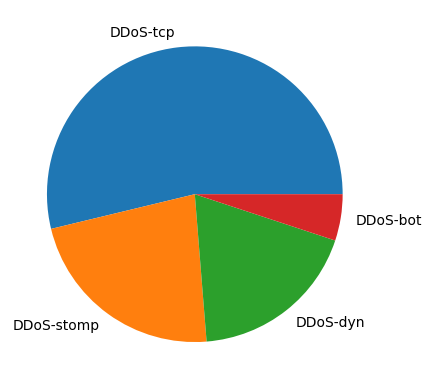

In [ ]:
ddos_directory_path = '/content/drive/MyDrive/Colab Notebooks/FLNET2023/DDOS'
ddos_df = generate_df(ddos_directory_path)

ddos_df.value_counts('label').plot(kind='pie')

Dataset-1.csv.zip
Dataset-2-hulk.csv.zip
Dataset-3.csv.zip
Dataset-4.csv.zip
Dataset-4-hulk.csv.zip
Dataset-6-hulk.csv.zip
Dataset-7-hulk.csv.zip
Dataset-8.csv.zip
Dataset-8-hulk.csv.zip
Dataset-9.csv.zip
Dataset-10.csv.zip


<Axes: >

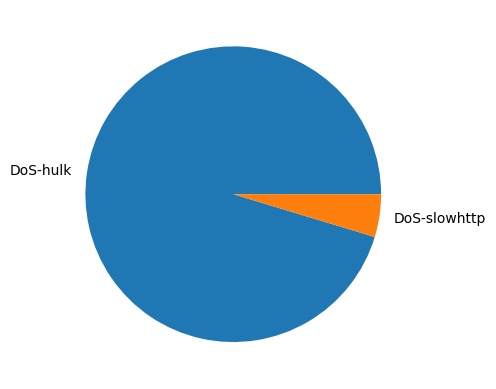

In [ ]:
dos_directory_path = '/content/drive/MyDrive/Colab Notebooks/FLNET2023/DOS'
dos_df = generate_df(dos_directory_path)

dos_df.value_counts('label').plot(kind='pie')

Dataset-1.csv.zip
Dataset-2.csv.zip
Dataset-3.csv.zip
Dataset-4.csv.zip
Dataset-5.csv.zip
Dataset-7.csv.zip
Dataset-9.csv.zip
Dataset-10.csv.zip


<Axes: >

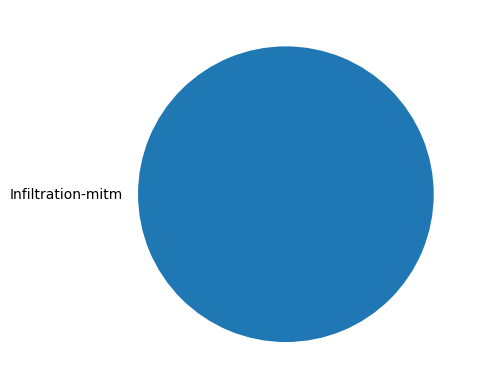

In [ ]:
infiltration_directory_path = '/content/drive/MyDrive/Colab Notebooks/FLNET2023/Infiltration'
infiltration_df = generate_df(infiltration_directory_path)

infiltration_df.value_counts('label').plot(kind='pie')

Dataset-1.csv.zip
Dataset-2.csv.zip
Dataset-3.csv.zip
Dataset-4.csv.zip
Dataset-5.csv.zip
Dataset-6.csv.zip
Dataset-7.csv.zip
Dataset-8.csv.zip
Dataset-9.csv.zip
Dataset-10.csv.zip


<Axes: >

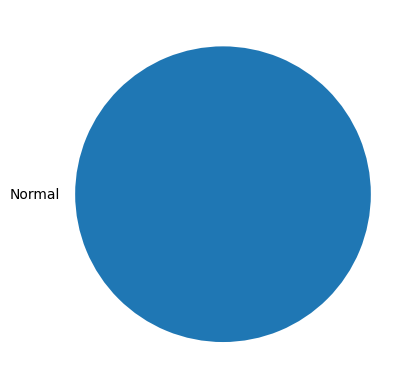

In [ ]:
normal_directory_path = '/content/drive/MyDrive/Colab Notebooks/FLNET2023/Normal'
normal_df = generate_df(normal_directory_path)

normal_df.value_counts('label').plot(kind='pie')

In [ ]:
# generate train data: normal + attacks
# get only a fraction or sample


df_list = [
    ddos_df,
    dos_df,
    infiltration_df,
    normal_df
]
train_data = pd.concat(df_list, ignore_index=True)

## Resize the Dataset

In [ ]:
# generate train data: normal + attacks
# get only a fraction based on the size of the smallest dataset

# df_list = [
#     ddos_df, # 1731066
#     dos_df, # 1725014
#     infiltration_df, # 28113
#     normal_df
# ]

# prev_size = 0
# max_size = 0
# for each in df_list:
#   current_size = len(each)
#   if prev_size == 0:
#     prev_size = current_size
#     continue

#   if current_size < prev_size:
#     prev_size = current_size
# max_size = prev_size

# df_list = [
#     ddos_df.sample(n=max_size),
#     dos_df.sample(n=max_size),
#     infiltration_df.sample(n=max_size),
#     normal_df.sample(n=max_size)
# ]
# train_data = pd.concat(df_list, ignore_index=True)

In [ ]:
# train_data.value_counts('label').plot(kind='pie')

In [ ]:
# resize to the smallest label
# new_train_data = pd.DataFrame()

# smallest_count = train_data['label'].value_counts().min()  # Get the smallest count based on the specific value of 'label' column

# new_train_data = train_data.groupby('label').sample(n=smallest_count) # Resize the DataFrame based on the smallest count

In [ ]:
# new_train_data['label'].value_counts()

In [ ]:
# train_data = new_train_data

## Inspect Training Data

<Axes: >

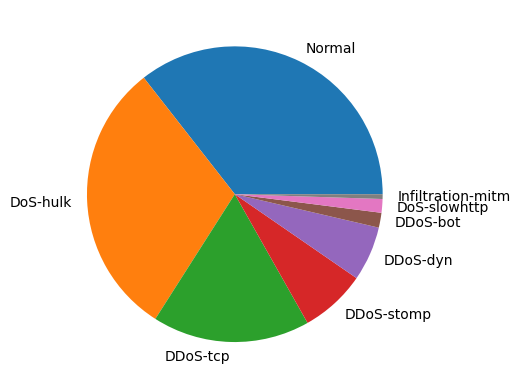

In [ ]:
train_data.value_counts('label').plot(kind='pie')

In [ ]:
train_data.columns

Index(['flow_duration', 'flow_byts_s', 'flow_pkts_s', 'fwd_pkts_s',
       'bwd_pkts_s', 'tot_fwd_pkts', 'tot_bwd_pkts', 'totlen_fwd_pkts',
       'totlen_bwd_pkts', 'fwd_pkt_len_max', 'fwd_pkt_len_min',
       'fwd_pkt_len_mean', 'fwd_pkt_len_std', 'bwd_pkt_len_max',
       'bwd_pkt_len_min', 'bwd_pkt_len_mean', 'bwd_pkt_len_std', 'pkt_len_max',
       'pkt_len_min', 'pkt_len_mean', 'pkt_len_std', 'pkt_len_var',
       'fwd_header_len', 'bwd_header_len', 'fwd_seg_size_min',
       'fwd_act_data_pkts', 'flow_iat_mean', 'flow_iat_max', 'flow_iat_min',
       'flow_iat_std', 'fwd_iat_tot', 'fwd_iat_max', 'fwd_iat_min',
       'fwd_iat_mean', 'fwd_iat_std', 'bwd_iat_tot', 'bwd_iat_max',
       'bwd_iat_min', 'bwd_iat_mean', 'bwd_iat_std', 'fin_flag_cnt',
       'down_up_ratio', 'pkt_size_avg', 'init_fwd_win_byts',
       'init_bwd_win_byts', 'active_max', 'active_min', 'active_mean',
       'active_std', 'idle_max', 'idle_min', 'idle_mean', 'idle_std',
       'fwd_byts_b_avg', 'fwd_pkts_b

In [ ]:
print(f"The shape of the training dataframe is : {train_data.shape}")  # check the dimensionality of the DataFrame

The shape of the training dataframe is : (1081345, 66)


In [ ]:
import gc
gc.collect()

58

## Generate Evaluation Data


bot.csv.zip
command-injection.csv.zip
dyn.csv.zip
hulk.csv.zip
mitm.csv.zip
normal.csv.zip
slowHttp.csv.zip
sql.csv.zip
stomp.csv.zip
tcp.csv.zip
xss.csv.zip


<Axes: >

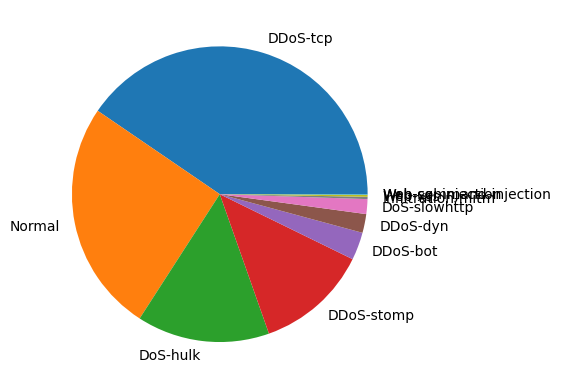

In [ ]:
eval_data_directory_path = '/content/drive/MyDrive/Colab Notebooks/FLNET2023/TEST'
eval_data = generate_df(eval_data_directory_path, 1)

eval_data.value_counts('label').plot(kind='pie')

In [ ]:
print(f"The shape of the testing dataframe is : {eval_data.shape}")

The shape of the testing dataframe is : (746617, 66)


## Preprocessing train data

### Shuffling the train data

In [ ]:
# shuffle the train data
from sklearn.utils import shuffle
train_data = shuffle(train_data, random_state=SEED)

In [ ]:
train_data.duplicated(keep="first")

254930    False
171540    False
591918    False
171147    False
462759    False
          ...  
5993      False
782888     True
18782     False
376059    False
134848    False
Length: 1081345, dtype: bool

In [ ]:
train_data = train_data.drop_duplicates()  # drop row duplicates

In [ ]:
train_data= train_data.dropna()  # drop missing values

In [ ]:
print(f"The shape of the training dataframe is : {train_data.shape}")  # check the dimensionality of the DataFrame

The shape of the training dataframe is : (692100, 66)


### Generating the X and y dataset for training

In [ ]:
print("Generating X dataset from dataset by dropping the following columns: label")
X = train_data.drop(['label'], axis=1)  # set X with removed columns: labels

Generating X dataset from dataset by dropping the following columns: label


In [ ]:
print("Generating y dataset from dataset by getting only the values in Label column")
y = train_data['label']  # set Y with label column only

Generating y dataset from dataset by getting only the values in Label column


In [ ]:
X.head()

,flow_duration,flow_byts_s,flow_pkts_s,fwd_pkts_s,bwd_pkts_s,tot_fwd_pkts,tot_bwd_pkts,totlen_fwd_pkts,totlen_bwd_pkts,fwd_pkt_len_max,fwd_pkt_len_min,fwd_pkt_len_mean,fwd_pkt_len_std,bwd_pkt_len_max,bwd_pkt_len_min,bwd_pkt_len_mean,bwd_pkt_len_std,pkt_len_max,pkt_len_min,pkt_len_mean,pkt_len_std,pkt_len_var,fwd_header_len,bwd_header_len,fwd_seg_size_min,fwd_act_data_pkts,flow_iat_mean,flow_iat_max,flow_iat_min,flow_iat_std,fwd_iat_tot,fwd_iat_max,fwd_iat_min,fwd_iat_mean,fwd_iat_std,bwd_iat_tot,bwd_iat_max,bwd_iat_min,bwd_iat_mean,bwd_iat_std,fin_flag_cnt,down_up_ratio,pkt_size_avg,init_fwd_win_byts,init_bwd_win_byts,active_max,active_min,active_mean,active_std,idle_max,idle_min,idle_mean,idle_std,fwd_byts_b_avg,fwd_pkts_b_avg,bwd_byts_b_avg,bwd_pkts_b_avg,fwd_blk_rate_avg,bwd_blk_rate_avg,fwd_seg_size_avg,bwd_seg_size_avg,subflow_fwd_pkts,subflow_bwd_pkts,subflow_fwd_byts,subflow_bwd_byts
254930,5521791,2.138002e+04,24.629690,17.747865,6.881825,98,38,115086,2970,1516,56,1174.346939,543.392971,253,68,78.157895,41.249259,1516,56,868.058824,674.674025,455185.040657,1960,760,20,92,40902.155556,5508233,0,4.723065e+05,5521791,5508233,0,56925.680412,5.563730e+05,5521760,5508248,1,149236.756757,8.931705e+05,1,0.387755,868.058824,64240,281,5508232,12,2.754122e+06,2.754110e+06,5508221,11569,2.759895e+06,2.748326e+06,54215.0,46.0,0.000000,0.0,2.004251e+08,0.000000e+00,1174.346939,78.157895,98,38,115086,2970
171540,260,1.171808e+08,188461.538462,111538.461538,76923.076923,29,20,28604,1863,1092,68,986.344828,311.042771,563,68,93.150000,107.805044,1092,68,621.775510,504.700973,254723.072053,580,400,20,26,5.416667,12,0,4.271189e+00,258,12,0,9.214286,2.289060e+00,258,39,10,13.578947,7.278778e+00,1,0.689655,621.775510,64240,501,0,0,0.000000e+00,0.000000e+00,0,0,0.000000e+00,0.000000e+00,13312.0,13.0,0.000000,0.0,1.157565e+08,0.000000e+00,986.344828,93.150000,29,20,28604,1863
591918,19925922,7.134425e+02,4.115242,2.408922,1.706320,48,34,6056,8160,459,56,126.166667,128.371098,644,68,240.000000,228.038696,644,56,173.365854,185.345788,34353.061273,960,680,20,8,245999.037037,7819155,0,1.269294e+06,19925922,7819155,0,423955.787234,1.643515e+06,19925864,7819171,0,603814.060606,1.933521e+06,1,0.708333,173.365854,64240,501,6793070,1,4.031852e+06,2.915171e+06,7819154,5302486,6.638237e+06,1.033242e+06,0.0,0.0,1446.000000,4.0,0.000000e+00,1.087218e+07,126.166667,240.000000,48,34,6056,8160
171147,258,1.317171e+08,205426.356589,124031.007752,81395.348837,32,21,31880,2103,1092,68,996.250000,297.701088,747,56,100.142857,144.675758,1092,56,641.188679,503.892736,253907.888928,640,420,20,29,4.961538,16,0,3.741460e+00,256,17,2,8.258065,2.816630e+00,254,45,1,12.700000,1.060236e+01,1,0.656250,641.188679,64240,0,0,0,0.000000e+00,0.000000e+00,0,0,0.000000e+00,0.000000e+00,14848.0,14.5,0.000000,0.0,1.362202e+08,0.000000e+00,996.250000,100.142857,32,21,31880,2103
462759,17481387,1.834065e+03,10.639888,6.292407,4.347481,110,76,13580,18482,443,56,123.454545,126.342510,654,68,243.184211,231.913988,654,56,172.376344,186.763200,34880.492774,2200,1520,20,18,94493.983784,3749690,0,4.946280e+05,17481387,3749690,0,160379.697248,6.361420e+05,17481373,3749704,0,233084.973333,7.557729e+05,1,0.690909,172.376344,64240,507,3749689,1,2.055645e+06,1.228913e+06,3749690,933411,2.182266e+06,1.049707e+06,0.0,0.0,1463.333333,4.0,0.000000e+00,7.656977e+06,123.454545,243.184211,110,76,13580,18482


In [ ]:
y.head()

254930    DDoS-stomp
171540      DDoS-tcp
591918      DoS-hulk
171147      DDoS-tcp
462759      DoS-hulk
Name: label, dtype: object

In [ ]:
y_new = pd.get_dummies(train_data['label'])
y_new.columns

Index(['DDoS-bot', 'DDoS-dyn', 'DDoS-stomp', 'DDoS-tcp', 'DoS-hulk',
       'DoS-slowhttp', 'Infiltration-mitm', 'Normal'],
      dtype='object')

In [ ]:
y_new.iloc[0]

DDoS-bot             0
DDoS-dyn             0
DDoS-stomp           1
DDoS-tcp             0
DoS-hulk             0
DoS-slowhttp         0
Infiltration-mitm    0
Normal               0
Name: 254930, dtype: uint8

In [ ]:
#Split data: 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y_new, test_size = 0.2, random_state = SEED)

In [ ]:
#Use StandardScaler() to standardize data - explained in Honours Project
sc = StandardScaler()
sc.fit(np.array(X_train))

StandardScaler()

In [ ]:
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


## Create Training Client Data

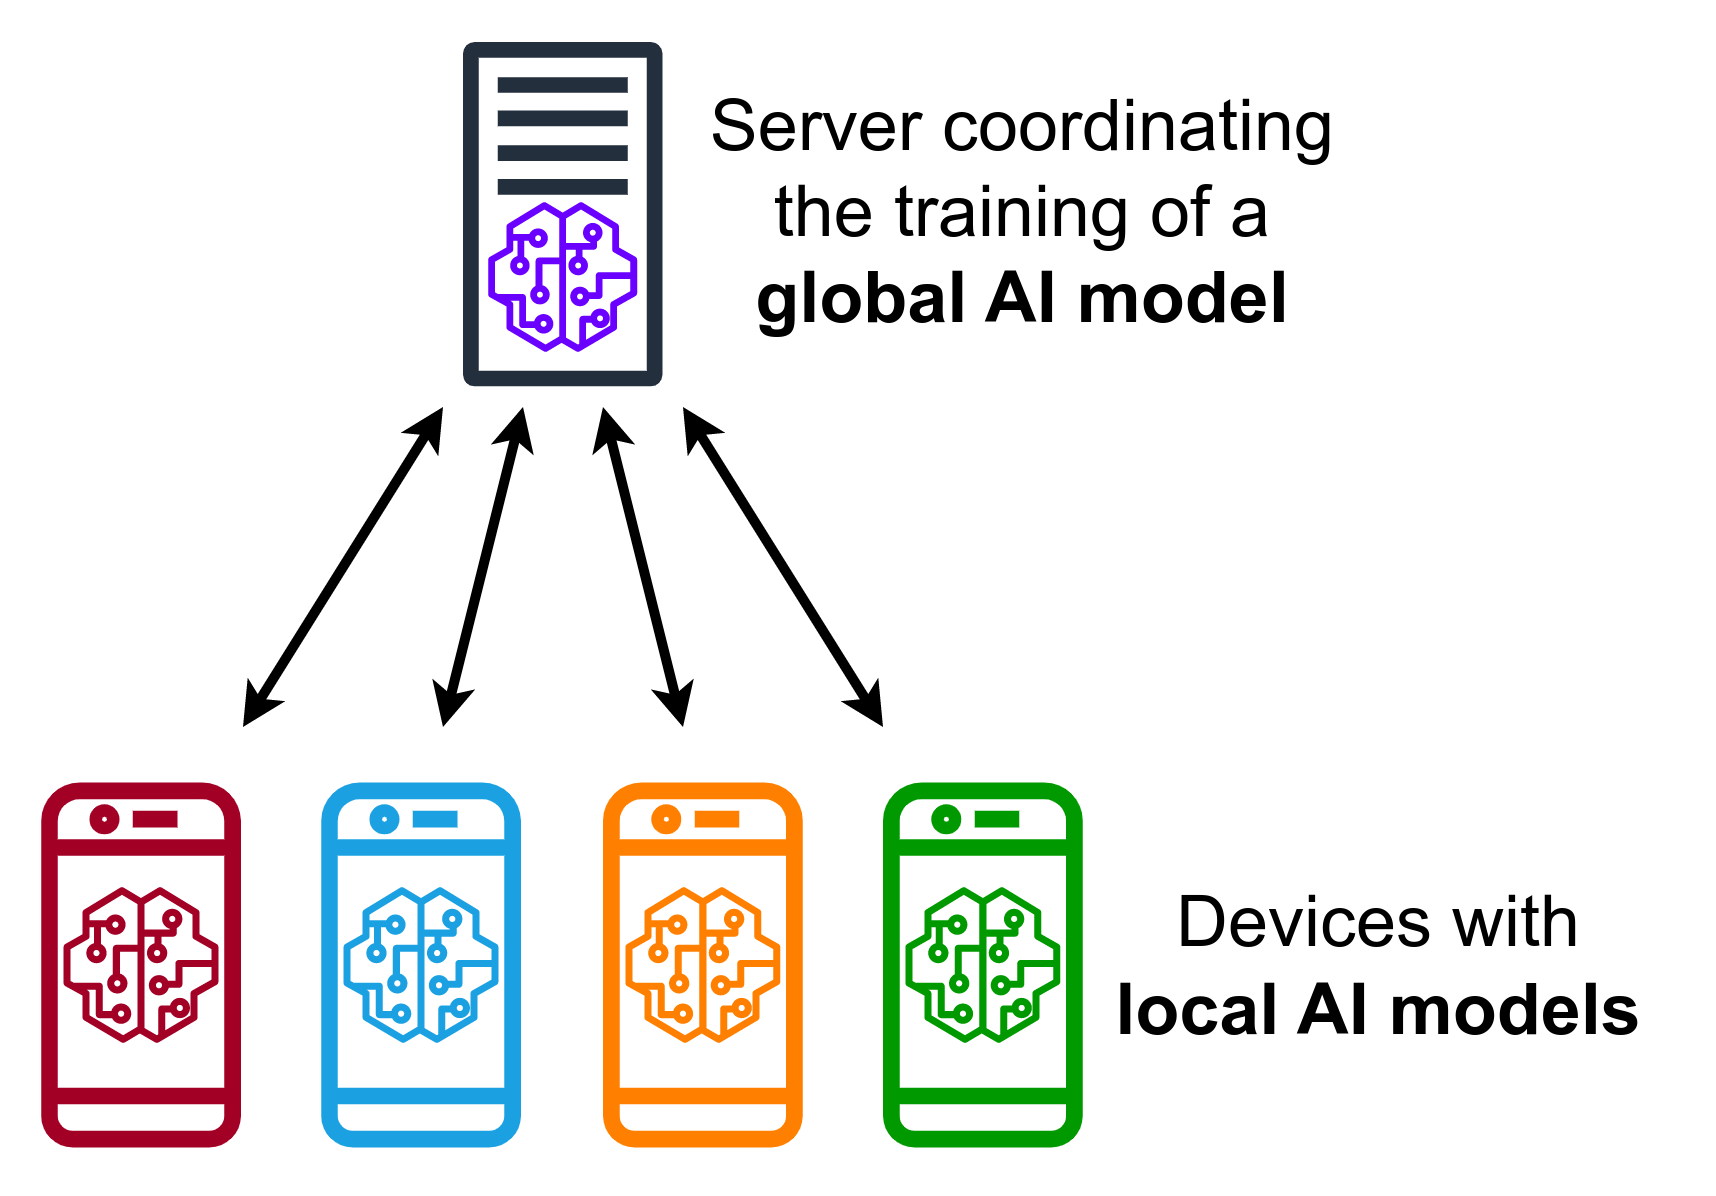

In [ ]:
def make_dataset(X, Y):
    return tf.data.Dataset.from_tensor_slices(
        collections.OrderedDict(
            x=tf.constant(X),
            y=tf.constant(Y)
        )
    )

len_train = len(X_train)
unit_chunk = len_train // NUM_CLIENTS

def client_data(n):
    start, end = unit_chunk * n, unit_chunk * (n + 1)
    train = make_dataset(X_train[start: end], y_train[start: end])
    return train.shuffle(unit_chunk, seed=SEED).batch(BATCH_SIZE).repeat(NUM_EPOCHES)

In [ ]:
client_train_data = [client_data(n) for n in range(NUM_CLIENTS)]

element_spec = client_train_data[0].element_spec
element_spec

OrderedDict([('x', TensorSpec(shape=(None, 65), dtype=tf.float64, name=None)),
             ('y', TensorSpec(shape=(None, 8), dtype=tf.uint8, name=None))])

## Create Testing Client Data

In [ ]:
def test_client_data(n):
    start, end = unit_chunk * n, unit_chunk * (n + 1)
    train = make_dataset(X_test[start: end], y_test[start: end])
    return train.shuffle(unit_chunk, seed=SEED).batch(BATCH_SIZE).repeat(NUM_EPOCHES)

In [ ]:
client_test_data = [test_client_data(n) for n in range(NUM_CLIENTS)]
client_test_data[0].element_spec

OrderedDict([('x', TensorSpec(shape=(None, 65), dtype=tf.float64, name=None)),
             ('y', TensorSpec(shape=(None, 8), dtype=tf.uint8, name=None))])

## Create Evaluation Client Data

In [ ]:
X_eval = eval_data.drop(['label'], axis=1)  # set X with removed columns: labels
X_eval.head()

,flow_duration,flow_byts_s,flow_pkts_s,fwd_pkts_s,bwd_pkts_s,tot_fwd_pkts,tot_bwd_pkts,totlen_fwd_pkts,totlen_bwd_pkts,fwd_pkt_len_max,fwd_pkt_len_min,fwd_pkt_len_mean,fwd_pkt_len_std,bwd_pkt_len_max,bwd_pkt_len_min,bwd_pkt_len_mean,bwd_pkt_len_std,pkt_len_max,pkt_len_min,pkt_len_mean,pkt_len_std,pkt_len_var,fwd_header_len,bwd_header_len,fwd_seg_size_min,fwd_act_data_pkts,flow_iat_mean,flow_iat_max,flow_iat_min,flow_iat_std,fwd_iat_tot,fwd_iat_max,fwd_iat_min,fwd_iat_mean,fwd_iat_std,bwd_iat_tot,bwd_iat_max,bwd_iat_min,bwd_iat_mean,bwd_iat_std,fin_flag_cnt,down_up_ratio,pkt_size_avg,init_fwd_win_byts,init_bwd_win_byts,active_max,active_min,active_mean,active_std,idle_max,idle_min,idle_mean,idle_std,fwd_byts_b_avg,fwd_pkts_b_avg,bwd_byts_b_avg,bwd_pkts_b_avg,fwd_blk_rate_avg,bwd_blk_rate_avg,fwd_seg_size_avg,bwd_seg_size_avg,subflow_fwd_pkts,subflow_bwd_pkts,subflow_fwd_byts,subflow_bwd_byts
0,28762,3.483207e+06,4797.997358,3407.273486,1390.723872,98,40,97054,3130,1516,56,990.346939,436.605812,253,68,78.250000,40.206809,1516,56,725.971014,554.149380,307081.535392,1960,800,20,92,209.941606,16119,0,1.722095e+03,28762,16143,0,296.515464,2.042275e+03,28748,16119,0,737.128205,3.171517e+03,1,0.408163,725.971014,64240,318,0,0,0.000000e+00,0.000000e+00,16118,12349,14233.50,1.884500e+03,90398.0,92.0,0.0,0.0,7.175014e+06,0.0,990.346939,78.250000,98,40,97054,3130
1,36055,1.222133e+06,2662.598807,1664.124255,998.474553,60,36,41230,2834,1516,56,687.166667,271.388539,253,68,78.722222,42.308136,1516,56,459.000000,365.335861,133470.291667,1200,720,20,54,379.526316,20668,0,2.605927e+03,36055,20681,0,611.101695,3.286644e+03,36039,35932,0,1029.685714,5.985698e+03,1,0.600000,459.000000,64240,467,15219,1,7.610000e+03,7.609000e+03,20667,15219,17943.00,2.724000e+03,37158.0,54.0,0.0,0.0,2.419456e+06,0.0,687.166667,78.722222,60,36,41230,2834
2,10333,3.799671e+06,9097.067647,5613.084293,3483.983354,58,36,36428,2834,723,56,628.068966,215.057640,253,68,78.722222,42.308136,723,56,417.680851,317.073326,100535.493889,1160,720,20,52,111.107527,10166,0,1.048297e+03,10333,10178,0,181.280702,1.335870e+03,10316,10207,0,294.742857,1.699942e+03,1,0.620690,417.680851,64240,467,0,0,0.000000e+00,0.000000e+00,0,0,0.00,0.000000e+00,32492.0,52.0,0.0,0.0,2.371679e+08,0.0,628.068966,78.722222,58,36,36428,2834
3,29635059,5.029111e+03,7.896053,5.331523,2.564530,158,76,143074,5964,1516,56,905.531646,400.760917,253,68,78.473684,41.216206,1516,56,636.914530,508.924466,259004.112353,3160,1520,20,146,127189.094421,29456268,0,1.925574e+06,29635059,29456268,0,188758.337580,2.343307e+06,29635050,29456292,0,395134.000000,3.378336e+06,1,0.481013,636.914530,64240,317,29456268,12125,9.827081e+06,1.387993e+07,29456266,12127,7407985.75,1.272971e+07,66173.0,73.0,0.0,0.0,5.109095e+06,0.0,905.531646,78.473684,158,76,143074,5964
4,137301,7.126532e+05,990.524468,699.193742,291.330726,96,40,94718,3130,1516,56,986.645833,432.775081,253,68,78.250000,40.206809,1516,56,719.470588,551.363270,304001.455017,1920,800,20,90,1017.044444,68665,0,6.818626e+03,137301,68711,0,1445.273684,8.100139e+03,137285,68665,0,3520.128205,1.306176e+04,1,0.416667,719.470588,64240,365,27943,12453,2.268733e+04,7.237650e+03,68664,12453,34181.75,2.087180e+04,88198.0,90.0,0.0,0.0,1.286266e+06,0.0,986.645833,78.250000,96,40,94718,3130


In [ ]:
y_eval = eval_data['label']  # set Y with label column only

y_eval_new = pd.get_dummies(y_eval)
y_eval_new.columns

# to fit with training data the following columns are removed:
# 'Web-command-injection','Web-sql-injection', 'Web-xss'
y_eval_new_filtered = y_eval_new.drop(['Web-command-injection','Web-sql-injection', 'Web-xss'], axis=1)
y_eval_new_filtered.head()

,DDoS-bot,DDoS-dyn,DDoS-stomp,DDoS-tcp,DoS-hulk,DoS-slowhttp,Infiltration-mitm,Normal
0,1,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0


In [ ]:
# add scaling
X_eval = sc.transform(X_eval)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [ ]:
def eval_client_data(n):
    start, end = unit_chunk * n, unit_chunk * (n + 1)
    train = make_dataset(X_eval[start: end], y_eval_new_filtered[start: end])
    return train.shuffle(unit_chunk, seed=SEED).batch(BATCH_SIZE).repeat(NUM_EPOCHES)

In [ ]:
client_eval_data = [eval_client_data(n) for n in range(NUM_CLIENTS)]
client_eval_data[0].element_spec

OrderedDict([('x', TensorSpec(shape=(None, 65), dtype=tf.float64, name=None)),
             ('y', TensorSpec(shape=(None, 8), dtype=tf.uint8, name=None))])

In [ ]:
import gc
gc.collect()

0

# Build Model

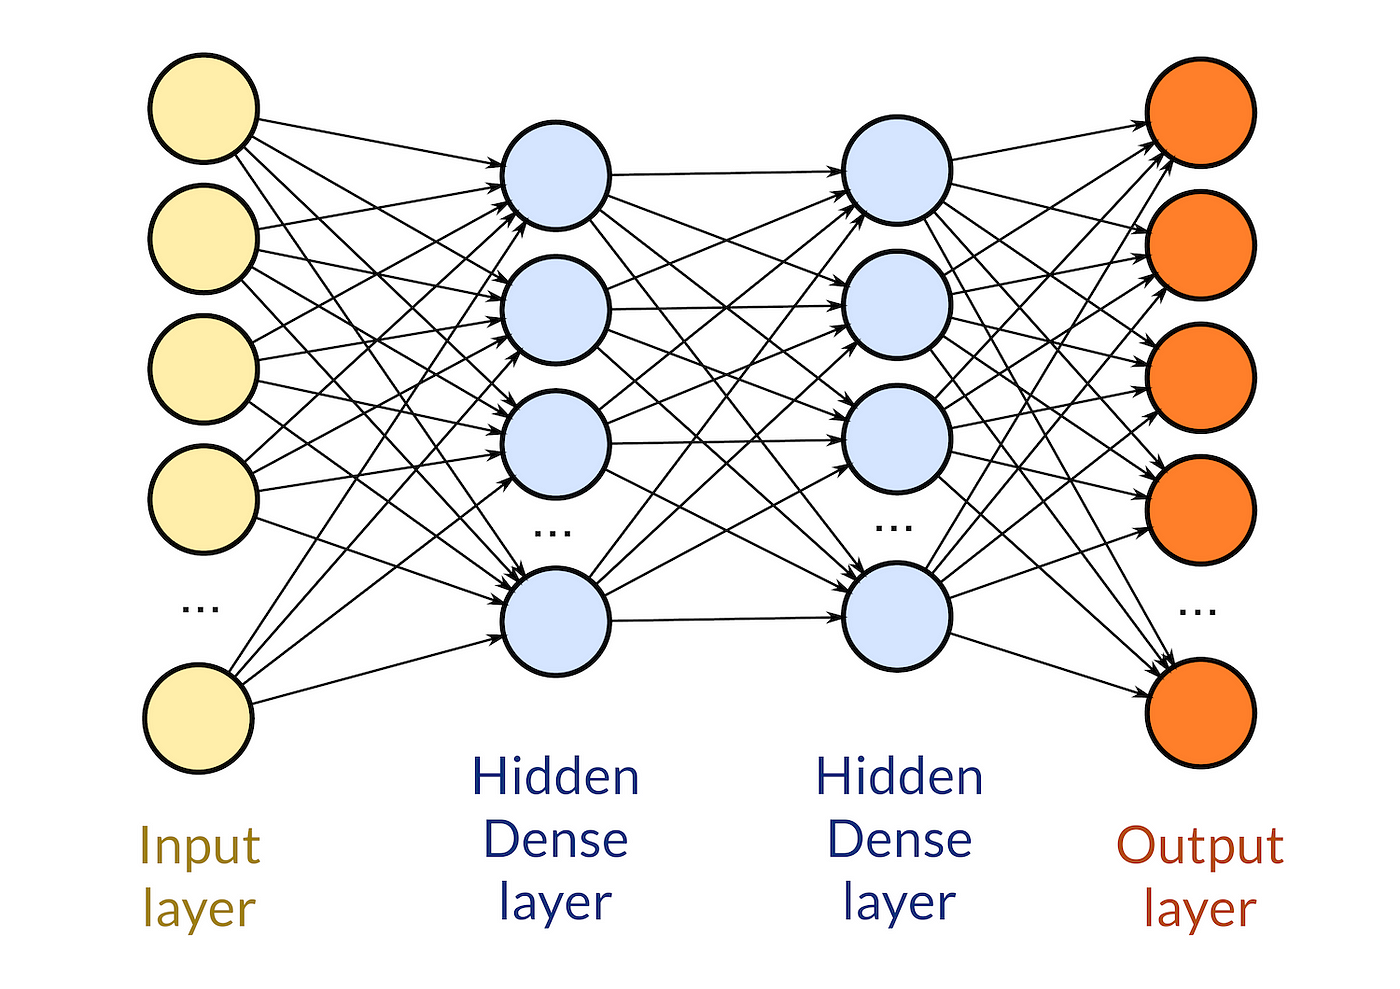

In [ ]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, input_dim = 65, activation = "relu", kernel_initializer = "lecun_normal"),
        tf.keras.layers.Dense(128, activation = "relu"),
        tf.keras.layers.Dense(8, activation = "softmax")
    ])
    return model

def model_fn():
    model = create_model()
    return tff.learning.models.from_keras_model(
        model,
        input_spec=element_spec,
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=[
            tf.keras.metrics.CategoricalAccuracy()
        ]
    )

# Training

In [ ]:
trainer = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn = lambda: tf.keras.optimizers.Adam(LEARNING_RATE)
)

In [ ]:
def training(trainer, state, nb_round=4):
    history = []
    for _ in range(nb_round):
        start_t = time.time()
        state, metrics = trainer.next(state, client_train_data)
        history.append(metrics['client_work']['train'])
        train_metrics = metrics['client_work']['train']
        end_t = time.time()
        print('train metrics {m}, round time {t:.2f} seconds'.format(m=train_metrics, t=(end_t - start_t)))
    return state, history

In [ ]:
state = trainer.initialize()  #  initializes the process
final_state, history = training(trainer, state)  # default of 4 rounds

train metrics OrderedDict([('categorical_accuracy', 0.9888365), ('loss', 0.051704217), ('num_examples', 553680), ('num_batches', 17310)]), round time 31.90 seconds
train metrics OrderedDict([('categorical_accuracy', 0.9975491), ('loss', 0.016000066), ('num_examples', 553680), ('num_batches', 17310)]), round time 27.89 seconds
train metrics OrderedDict([('categorical_accuracy', 0.9979194), ('loss', 0.01443703), ('num_examples', 553680), ('num_batches', 17310)]), round time 25.69 seconds
train metrics OrderedDict([('categorical_accuracy', 0.998174), ('loss', 0.013755193), ('num_examples', 553680), ('num_batches', 17310)]), round time 27.25 seconds


# Visualizing Training Result

In [ ]:
acc_his = [result['categorical_accuracy'] for result in history]
loss_his = [result['loss'] for result in history]

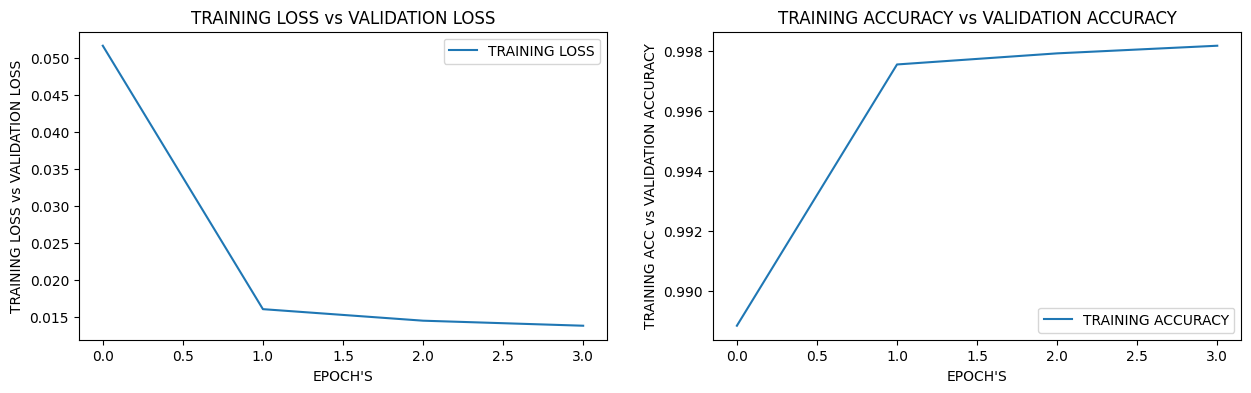

In [ ]:
#use matplitlib to draw the plots
plt.figure(figsize = (15, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_his, label = "TRAINING LOSS")
plt.title("TRAINING LOSS vs VALIDATION LOSS")
plt.xlabel("EPOCH'S")
plt.ylabel("TRAINING LOSS vs VALIDATION LOSS")
plt.legend(loc = "best")

plt.subplot(1, 2, 2)
plt.plot(acc_his, label = "TRAINING ACCURACY")
plt.title("TRAINING ACCURACY vs VALIDATION ACCURACY")
plt.xlabel("EPOCH'S")
plt.ylabel("TRAINING ACC vs VALIDATION ACCURACY")
plt.legend(loc = "best")

# Evaluate Model using Keras evaluate function

https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate



In [ ]:
eval_model = create_model()  # define the model
eval_model.compile(tf.keras.optimizers.Adam(learning_rate=0.02), 'categorical_crossentropy', metrics=['acc'])

model_weights = trainer.get_model_weights(final_state)  # get the weights of the earlier trained model

In [ ]:
eval_model.set_weights(model_weights.trainable)  # set weights to the eval_model
loss, acc = eval_model.evaluate(X_test, y_test)  # evaluate

4326/4326 [==============================] - 8s 2ms/step - loss: 0.1087 - acc: 0.9987


In [ ]:
print(f'Test Accuracy: { acc }')

Test Accuracy: 0.9986996054649353


In [ ]:
loss, acc = eval_model.evaluate(X_eval, y_eval_new_filtered)  # evaluate
print(f'Test Accuracy: { acc }')

23332/23332 [==============================] - 48s 2ms/step - loss: 0.4692 - acc: 0.9677
Test Accuracy: 0.9677143692970276


# Evaluate Model using TFF build_fed_eval function

https://www.tensorflow.org/federated/api_docs/python/tff/learning/algorithms/build_fed_eval

In [ ]:
evaluation_model = tff.learning.algorithms.build_fed_eval(model_fn)  # define eval function uses the untrained model

In [ ]:
print(evaluation_model.next.type_signature.formatted_representation())

(<
  state=<
    global_model_weights=<
      trainable=<
        float32[65,64],
        float32[64],
        float32[64,128],
        float32[128],
        float32[128,8],
        float32[8]
      >,
      non_trainable=<>
    >,
    distributor=<>,
    client_work=<
      <>,
      <
        categorical_accuracy=<
          float32,
          float32
        >,
        loss=<
          float32,
          float32
        >,
        num_examples=<
          int64
        >,
        num_batches=<
          int64
        >
      >
    >,
    aggregator=<
      value_sum_process=<>,
      weight_sum_process=<>
    >,
    finalizer=<>
  >@SERVER,
  client_data={<
    x=float64[?,65],
    y=uint8[?,8]
  >*}@CLIENTS
> -> <
  state=<
    global_model_weights=<
      trainable=<
        float32[65,64],
        float32[64],
        float32[64,128],
        float32[128],
        float32[128,8],
        float32[8]
      >,
      non_trainable=<>
    >,
    distributor=<>,
    client_work=<
     

In [ ]:
evaluation_state = evaluation_model.initialize()  # initialize
model_weights = trainer.get_model_weights(final_state)  # get the weights from the trained model
evaluation_state = evaluation_model.set_model_weights(evaluation_state, model_weights)

In [ ]:
evaluation_output = evaluation_model.next(evaluation_state, client_test_data)  # evaluate using the trained model with train data

In [ ]:
str(evaluation_output.metrics)

"OrderedDict([('distributor', ()), ('client_work', OrderedDict([('eval', OrderedDict([('current_round_metrics', OrderedDict([('categorical_accuracy', 0.9986996), ('loss', 0.012582461), ('num_examples', 138420), ('num_batches', 4328)])), ('total_rounds_metrics', OrderedDict([('categorical_accuracy', 0.9986996), ('loss', 0.012582461), ('num_examples', 138420), ('num_batches', 4328)]))]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])"

## Evaluating using Evaluation Data

In [ ]:
evaluation_output_eval = evaluation_model.next(evaluation_state, client_eval_data) # evaluate using the trained model with eval data

In [ ]:
str(evaluation_output_eval.metrics)

"OrderedDict([('distributor', ()), ('client_work', OrderedDict([('eval', OrderedDict([('current_round_metrics', OrderedDict([('categorical_accuracy', 0.9602496), ('loss', 0.3477293), ('num_examples', 553680), ('num_batches', 17310)])), ('total_rounds_metrics', OrderedDict([('categorical_accuracy', 0.9602496), ('loss', 0.3477293), ('num_examples', 553680), ('num_batches', 17310)]))]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])"

# Confusion Matrix using Tensorboard

In [ ]:
# import sklearn


# def log_confusion_matrix(epoch, logs):

#     # Use the model to predict the values from the test_images.
#     test_pred_raw = model.predict(test_images)

#     test_pred = np.argmax(test_pred_raw, axis=1)

#     # Calculate the confusion matrix using sklearn.metrics
#     cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)

#     figure = plot_confusion_matrix(cm, class_names=class_names)
#     cm_image = plot_to_image(figure)

#     # Log the confusion matrix as an image summary.
#     with file_writer_cm.as_default():
#         tf.summary.image("Confusion Matrix", cm_image, step=epoch)

In [ ]:
# NUM_ROUNDS = 11

# with summary_writer.as_default():
#   for round_num in range(1, NUM_ROUNDS):
#     result = trainer.next(train_state, federated_train_data)
#     train_state = result.state
#     train_metrics = result.metrics
#     for name, value in train_metrics['client_work']['train'].items():
#       tf.summary.scalar(name, value, step=round_num)

# ROC
https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

In [ ]:
# call the model creation function
eval_model = create_model()
eval_model.compile(tf.keras.optimizers.Adam(learning_rate=0.02), 'categorical_crossentropy', metrics=['acc'])
# get the weights of the server model from the training process
model_weights = trainer.get_model_weights(final_state)  # get the weights from the trained model
# assign these weights to the evaluation model we just created
model_weights.assign_weights_to(eval_model)

In [ ]:
# for test data
y_pred = eval_model.predict(X_test)

4326/4326 [==============================] - 8s 2ms/step


In [ ]:
print ("Val shape after preprocessing:", X_eval.shape, y_eval_new_filtered.shape)

Val shape after preprocessing: (746617, 65) (746617, 8)


In [ ]:
# for eval data
y_pred_eval = eval_model.predict(X_eval)

23332/23332 [==============================] - 45s 2ms/step


### Checking the result for test data

The target class is the class with the value of 1. Checking the first entry.

In [ ]:
print("y_test shape: {}".format(y_test.shape))
print("y_test first entry value:\n{}".format(y_test.iloc[0]))

y_test shape: (138420, 8)
y_test first entry value:
DDoS-bot             0
DDoS-dyn             0
DDoS-stomp           1
DDoS-tcp             0
DoS-hulk             0
DoS-slowhttp         0
Infiltration-mitm    0
Normal               0
Name: 217643, dtype: uint8


In [ ]:
# get the class by getting list of columns from the testing data
class_list = y_test.columns
print("List of class: {}".format(class_list))

List of class: Index(['DDoS-bot', 'DDoS-dyn', 'DDoS-stomp', 'DDoS-tcp', 'DoS-hulk',
       'DoS-slowhttp', 'Infiltration-mitm', 'Normal'],
      dtype='object')


In [ ]:
print("y_pred first entry value:\n{}".format(y_pred[0]))

y_pred first entry value:
[1.7012085e-10 1.2769943e-06 9.9999863e-01 2.6832209e-10 5.6802802e-14
 1.4281334e-10 4.1052136e-13 8.4560527e-15]


In [ ]:
# get the highest value in the first entry of prediction using argmax
index_with_highest_value = y_pred[0].argmax()
print("Index with the highest value in the entry: {}".format(index_with_highest_value))
# using the class list, get the column by using the index of the highest value
print("Prediction is class: {}".format(class_list[index_with_highest_value]))

Index with the highest value in the entry: 2
Prediction is class: DDoS-stomp


### One vs All

In [ ]:
# for test data
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

(138420, 8)

In [ ]:
# for eval data

# label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_eval = label_binarizer.transform(y_eval_new_filtered)
y_onehot_eval.shape  # (n_samples, n_classes)

(746617, 8)

In [ ]:
y_train.columns

Index(['DDoS-bot', 'DDoS-dyn', 'DDoS-stomp', 'DDoS-tcp', 'DoS-hulk',
       'DoS-slowhttp', 'Infiltration-mitm', 'Normal'],
      dtype='object')

In [ ]:
y_test.columns

Index(['DDoS-bot', 'DDoS-dyn', 'DDoS-stomp', 'DDoS-tcp', 'DoS-hulk',
       'DoS-slowhttp', 'Infiltration-mitm', 'Normal'],
      dtype='object')

In [ ]:
y_eval_new_filtered.columns

Index(['DDoS-bot', 'DDoS-dyn', 'DDoS-stomp', 'DDoS-tcp', 'DoS-hulk',
       'DoS-slowhttp', 'Infiltration-mitm', 'Normal'],
      dtype='object')

In [ ]:
label_binarizer.classes_

array([0, 1, 2, 3, 4, 5, 6, 7])

In [ ]:
class_of_interest = 7
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

7

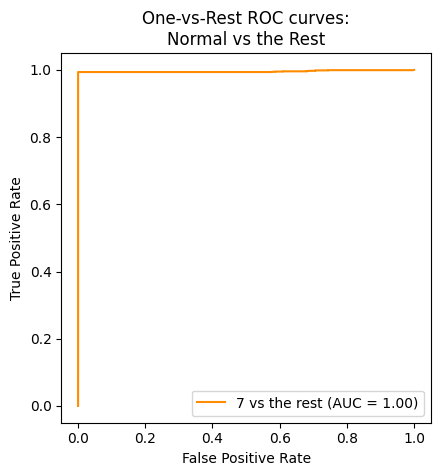

In [ ]:
# for test data
import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_pred[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    # plot_chance_level=True
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nNormal vs the Rest")
plt.legend()
plt.show()

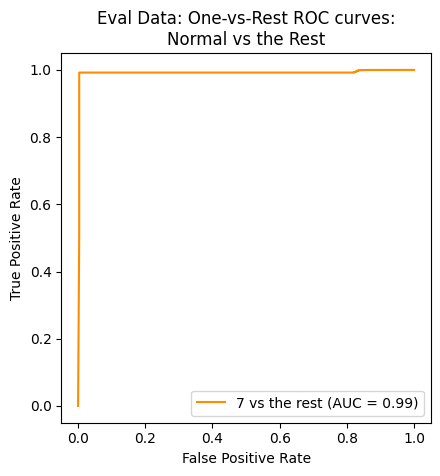

In [ ]:
# for eval data
RocCurveDisplay.from_predictions(
    y_onehot_eval[:, class_id],
    y_pred_eval[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    # plot_chance_level=True
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Eval Data: One-vs-Rest ROC curves:\nNormal vs the Rest")
plt.legend()
plt.show()

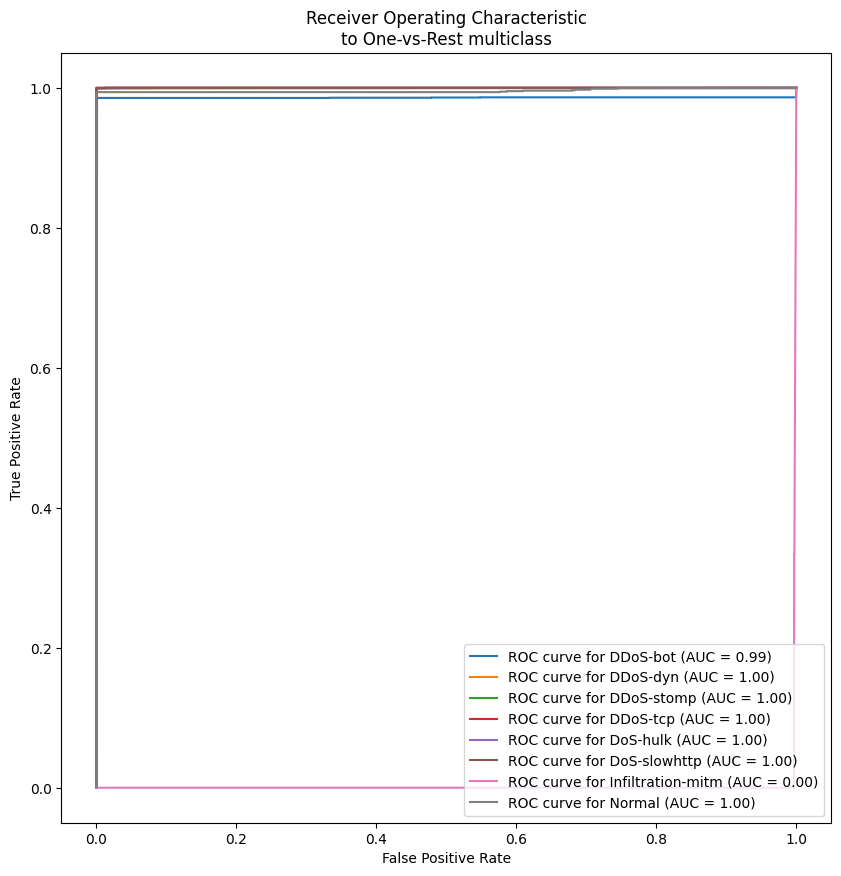

In [ ]:
# for testing data
custom_colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5',
    '#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d', '#9edae5',
    '#393b79', '#637939', '#8c6d31'
]

fig, ax = plt.subplots(figsize=(10, 10))

for i in label_binarizer.classes_:
  class_of_interest = i
  class_of_interest_str = y_train.columns[class_of_interest]

  RocCurveDisplay.from_predictions(
      y_onehot_test[:, class_of_interest],
      y_pred[:, class_of_interest],
      name=f"ROC curve for {class_of_interest_str}",
      color=custom_colors[i], # "darkorange",
      # plot_chance_level=True
      ax=ax
  )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic\nto One-vs-Rest multiclass")
  # plt.legend()
plt.show()

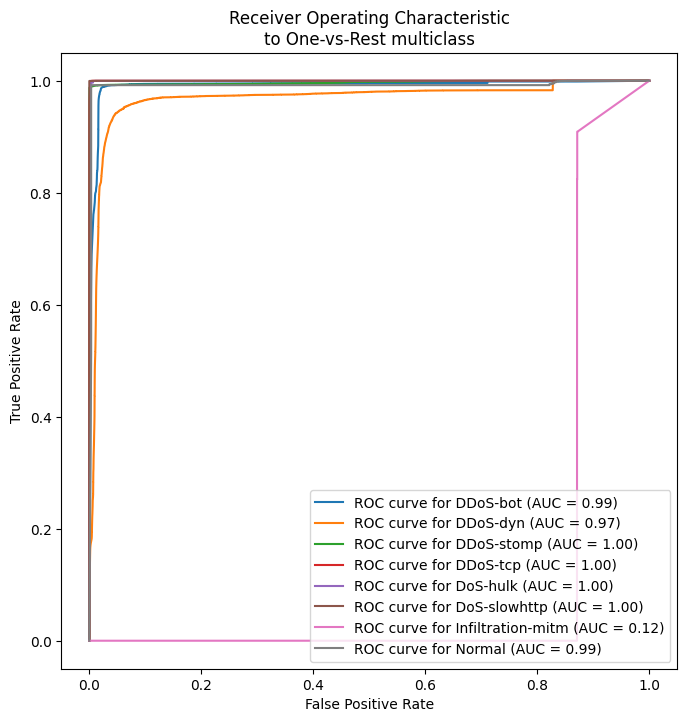

In [ ]:
# for eval data
custom_colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5',
    '#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d', '#9edae5',
    '#393b79', '#637939', '#8c6d31'
]

fig, ax = plt.subplots(figsize=(8, 8))

for i in label_binarizer.classes_:
  class_of_interest = i
  class_of_interest_str = y_train.columns[class_of_interest]

  RocCurveDisplay.from_predictions(
      y_onehot_eval[:, class_of_interest],
      y_pred_eval[:, class_of_interest],
      name=f"ROC curve for {class_of_interest_str}",
      color=custom_colors[i], # "darkorange",
      # plot_chance_level=True
      ax=ax
  )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic\nto One-vs-Rest multiclass")
  # plt.legend()
plt.show()

## ROC Curve: Normal vs Attack

In [ ]:
class_list[7]

'Normal'

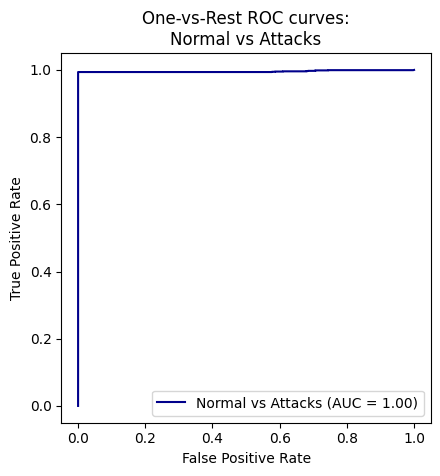

In [ ]:
# for test data
import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay

class_id = 7
RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_pred[:, class_id],
    name=f"Normal vs Attacks",
    color="darkblue",
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nNormal vs Attacks")
plt.legend()
plt.show()

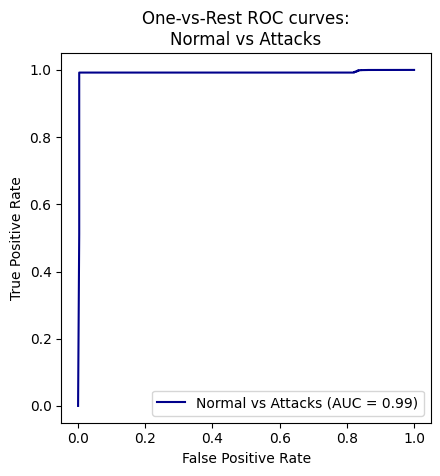

In [ ]:
# for eval data
import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay

class_id = 7
RocCurveDisplay.from_predictions(
    y_onehot_eval[:, class_id],
    y_pred_eval[:, class_id],
    name=f"Normal vs Attacks",
    color="darkblue",
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nNormal vs Attacks")
plt.legend()
plt.show()

## ROC curve using micro-averaged OvR
https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#roc-curve-using-micro-averaged-ovr

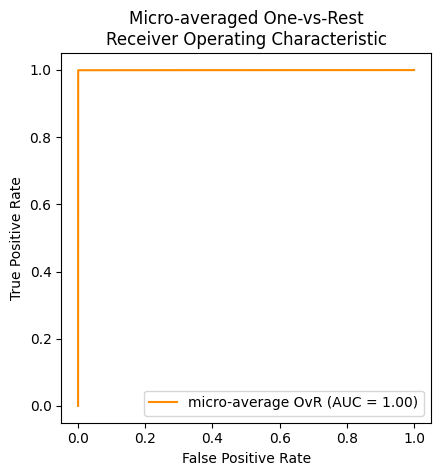

In [ ]:
# for test data
RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_pred.ravel(),
    name="micro-average OvR",
    color="darkorange",
    # plot_chance_level=True,
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

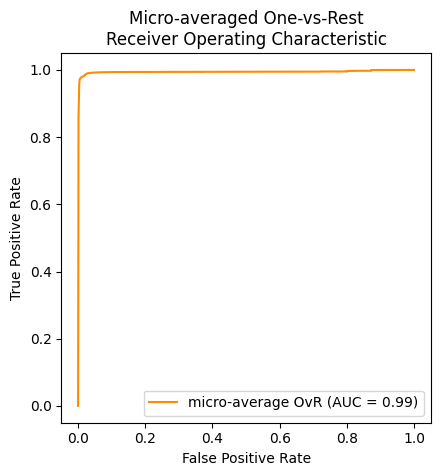

In [ ]:
# for eval data
RocCurveDisplay.from_predictions(
    y_onehot_eval.ravel(),
    y_pred_eval.ravel(),
    name="micro-average OvR",
    color="darkorange",
    # plot_chance_level=True,
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

## ROC Score

In [ ]:
from sklearn.metrics import roc_auc_score

micro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_pred,
    multi_class="ovr",
    average="micro",
)

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
1.00


In [ ]:
micro_roc_auc_ovr_eval = roc_auc_score(
    y_eval_new_filtered,
    y_pred_eval,
    multi_class="ovr",
    average="micro",
)

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
1.00


# Confusion Matrix

In [ ]:
# for test data
columns = y_test.columns
nb_columns = len(columns)
roc_matrix_multi = np.zeros((nb_columns, nb_columns), dtype=np.int32)
roc_matrix_binary = np.zeros((2, 2), dtype=np.int32)

In [ ]:
roc_matrix_multi

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)

In [ ]:
roc_matrix_binary

array([[0, 0],
       [0, 0]], dtype=int32)

In [ ]:
for corr, pred in zip(y_test.iloc, y_pred):

    corr_idx = np.argmax(corr)
    pred_idx = np.argmax(pred)

    # confusion matrix for all type of class (normal and all attacks)
    roc_matrix_multi[pred_idx][corr_idx] += 1
    # confusion matrix for normal and attack
    roc_matrix_binary[0 if columns[pred_idx] == 'Normal' else 1][0 if columns[corr_idx] == 'Normal' else 1] += 1

In [ ]:
x_axis_label = columns
y_axis_label = columns
plt.figure()
sns.heatmap(roc_matrix_multi, xticklabels=x_axis_label, yticklabels=y_axis_label, annot=True)

In [ ]:
for each in range(0,7):
 print(f"{x_axis_label[each]}, {roc_matrix_multi[each][each]}")

In [ ]:
x_axis_label = ['Normal', 'attack']
y_axis_label = ['Normal', 'attack']
plt.figure()
sns.heatmap(roc_matrix_binary, xticklabels=x_axis_label, yticklabels=y_axis_label, annot=True,annot_kws={"size": 16})

TP, FP, FN, TN = roc_matrix_binary[0][0], roc_matrix_binary[0][1], roc_matrix_binary[1][0], roc_matrix_binary[1][1]

acc = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
F1score = 2 * ((precision * recall) / (precision + recall))

TPR = round((TP / (TP + FN)), 6)

FPR = round((FP / (FP + TN)), 6)

print('Acc: %.3f%% \nPrecision: %.3f \nRecall: %.3f \nF1score: %.3f \nTPR: %.5f \nFPR: %.5f'%(acc*100,
                                                                                              precision,
                                                                                              recall,
                                                                                              F1score*100,
                                                                                              TPR,
                                                                                              FPR))

In [ ]:
# for eval data
columns = y_eval_new_filtered.columns
nb_columns = len(columns)
roc_matrix_multi_eval = np.zeros((nb_columns, nb_columns), dtype=np.int32)
roc_matrix_binary_eval = np.zeros((2, 2), dtype=np.int32)

for corr, pred in zip(y_eval_new_filtered.iloc, y_pred_eval):

    corr_idx = np.argmax(corr)
    pred_idx = np.argmax(pred)

    # confusion matrix for all type of class (normal and all attacks)
    roc_matrix_multi_eval[pred_idx][corr_idx] += 1
    # confusion matrix for normal and attack
    roc_matrix_binary_eval[0 if columns[pred_idx] == 'Normal' else 1][0 if columns[corr_idx] == 'Normal' else 1] += 1

In [ ]:
x_axis_label = columns
y_axis_label = columns
plt.figure(figsize = (15, 8))
sns.heatmap(roc_matrix_multi_eval, xticklabels=x_axis_label, yticklabels=y_axis_label, annot=True)

In [ ]:
for each in range(0,7):
 print(f"{x_axis_label[each]}, {roc_matrix_multi[each][each]}")

Acc: 99.487% 
Precision: 0.988 
Recall: 0.992 
F1score: 98.994 
TPR: 0.99210 
FPR: 0.00418


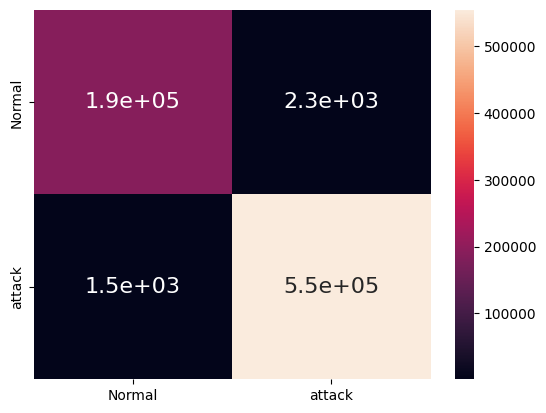

In [ ]:
x_axis_label = ['Normal', 'attack']
y_axis_label = ['Normal', 'attack']
plt.figure()
sns.heatmap(roc_matrix_binary_eval, xticklabels=x_axis_label, yticklabels=y_axis_label, annot=True,annot_kws={"size": 16})

TP, FP, FN, TN = roc_matrix_binary_eval[0][0], roc_matrix_binary_eval[0][1], roc_matrix_binary_eval[1][0], roc_matrix_binary_eval[1][1]

acc = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
F1score = 2 * ((precision * recall) / (precision + recall))

TPR = round((TP / (TP + FN)), 6)

FPR = round((FP / (FP + TN)), 6)

print('Acc: %.3f%% \nPrecision: %.3f \nRecall: %.3f \nF1score: %.3f \nTPR: %.5f \nFPR: %.5f'%(acc*100,
                                                                                              precision,
                                                                                              recall,
                                                                                              F1score*100,
                                                                                              TPR,
                                                                                              FPR))